### Notebook structure

- **Instructions**: set of important informations to understand the structure of the code and how to make it work.
- **Excercise 03.1**: Simulation via Monte Carlo of Europian call-option and put-option prices.

## Instructions

Intruction to C++ compilation and executions .

- To compile the code run in the directory 'es_03.1' the command :  `make`. 
- The code is divided into directories:
    - the directory 'random' contains all the files needed to use the RNG.
    - the directory 'utilities' contains files with userful functions and classes.
- To automatically execute the code run :  `make run`.
- To clear the files `.o`  please run `make clean`.
- The code generates output files in the  'output' directory.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

from astropy import table
from astropy.io import ascii

## Excercise 03.1

The goal here is to compute at time $t=0$ via Monte Carlo simulation the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$, using two different methods:

**Method 1**: By sampling directly the final asset price $S(T)$ for a geometric Brownian motion (GBM) process.

**Method 2**: By sampling the discretized GBM path of the asset price, dividing $[0,T]$ into $10^2$ time intervals.

For the Options parameters we consider the following values:
- Asset price at $t=0$: $S(0) = 100$
- Delivery time: $T = 1$
- Strike price: $K = 100$
- Risk-free interest rate: $r = 0.1$
- Volatility: $\sigma = 0.25$

First we use the Black-Scholes model to find the expected values for the prices

In [28]:
import scipy
from scipy.special import erf
import numpy
from numpy import exp
from numpy.lib.scimath import log, sqrt

# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    BS_call, BS_put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", BS_call)
    print("put: ", BS_put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


For the first Method we need to
- Generate random samples from a standard normal distribution to simulate the underlying asset's future price at time $T$.
- Calculate the call and put option payoffs at maturity. Using the following expression
$$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
and
$$
\begin{cases}
C[S(t),t]=\text{max}[0,S(T)-K] & \text{for call option}\\
P[S(t),t]=\text{max}[0,K-S(T)] & \text{for pull option}
\end{cases}
$$

- Compute the option prices by taking the mean of the payoffs and discounting them to the present value.

we do so $N_\text{throws}=10^4$ times for every block ($N_\text{block}=100$) and we evaluate the cumulative averages and uncertainty as a function of the blocks number.

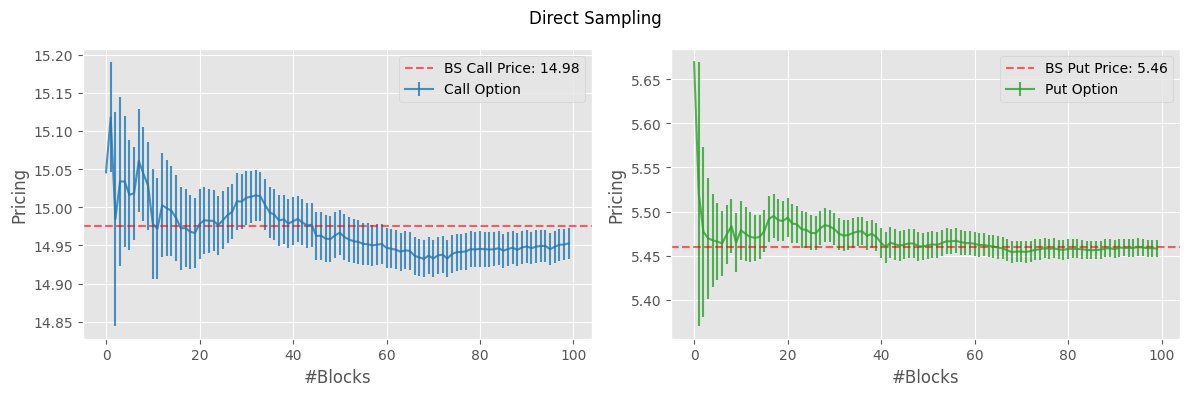

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

N = 100     # Number of blocks
L = 10000   # Number of throws in each block, please use for M a multiple of N

x = np.arange(N)   # Calculate the total number of throws for each block

# Read the data from the files using Astropy's ascii module
file_names = ['es_03.1/output/es03_1c.dat', 'es_03.1/output/es03_1p.dat']

# Labels for the legend
labels = ['Call', 'Put']

# Create subplots
# Use figsize to adjust the overall figure size
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, file_name in enumerate(file_names):
    df = ascii.read(file_name, names=['comulative_averages', 'uncertainty'])
    ave = df['comulative_averages']
    yerr = df['uncertainty']

    axs[i].errorbar(x, ave, yerr, color=f"tab:{'blue' if i == 0 else 'green'}",
                    ecolor=f"tab:{'blue' if i == 0 else 'green'}", label=f'{labels[i]} Option', alpha=0.8)
    axs[i].set_ylabel('Pricing')

    axs[i].grid(True)
    axs[i].axhline(y=BS_call if i == 0 else BS_put, linestyle="--", color='red',
                   label=f'BS {labels[i]} Price: {BS_call:.2f}' if i == 0 else f'BS {labels[i]} Price: {BS_put:.2f}', alpha=0.6)
    axs[i].set_xlabel('#Blocks')
    axs[i].legend()

plt.suptitle("Direct Sampling")

plt.tight_layout()  # Ensure proper spacing
plt.show()


For the second method we
- Divide the time interval $[0, T]$ into a finite number of discrete intervals $t_1 < t_2 < … < t_n$ (100 intervals in this case). 
- For each interval, generate random samples to simulate the asset price path using the discretized geometric Brownian motion (GBM) model.
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]  \qquad\text{with} Z_i \sim \mathcal{N}(0,1)$$
    


- Calculate the call and put option payoffs for each path at maturity.
- Compute the option prices by taking the mean of the payoffs and discounting them to the present value.

we do so $N_\text{throws}=10^4$ times for every block ($N_\text{block}=100$) and we evaluate the cumulative averages and uncertainty as a function of the blocks number.

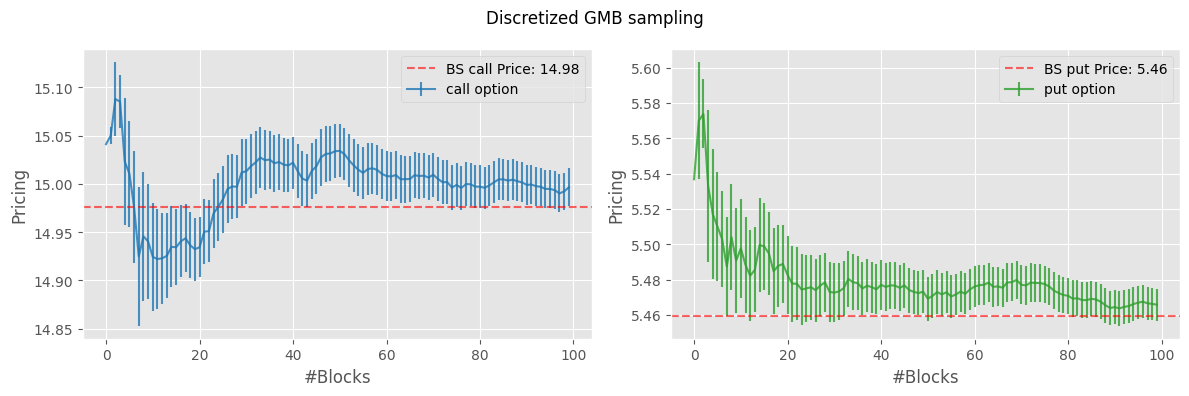

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

N = 100     # Number of blocks
L = 10000   # Number of throws in each block, please use for M a multiple of N

x = np.arange(N)   # Calculate the total number of throws for each block

# Read the data from the files using Astropy's ascii module
file_names = ['es_03.1/output/es03_2c.dat', 'es_03.1/output/es03_2p.dat']

# Labels for the legend
labels = ['call', 'put']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, file_name in enumerate(file_names):
    df = ascii.read(file_name, names=['comulative_averages', 'uncertainty'])
    ave = df['comulative_averages']
    yerr = df['uncertainty']
    
    row = i // 1  # Determine the row index
    col = i % 1   # Determine the column index
    
    axs[row].errorbar(x, ave, yerr, color=f"tab:{'blue' if i == 0 else 'green'}", 
                ecolor=f"tab:{'blue' if i == 0 else 'green'}", label=labels[i]+" option",alpha=0.8)
    axs[i].set_ylabel('Pricing')

    axs[i].grid(True)
    axs[i].axhline(y=BS_call if i == 0 else BS_put, linestyle="--", color='red',
                   label=f'BS {labels[i]} Price: {BS_call:.2f}' if i == 0 else f'BS {labels[i]} Price: {BS_put:.2f}', alpha=0.6)
    axs[i].set_xlabel('#Blocks')
    axs[i].legend()
    
plt.suptitle("Discretized GMB sampling")
plt.tight_layout()  # Ensure proper spacing
plt.show()




 The results from both methods provide similar option prices, demonstrating the consistency of Monte Carlo simulations for option pricing.